# Import Library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import cluster
from sklearn import mixture
from sklearn import preprocessing
from scipy import interpolate
from scipy.spatial import distance
from collections import Counter
from importlib import reload

# Data Preprocess

### Utility functions

In [2]:
def read_data(folder):
    """
    read particle property files for all 303 steps
    forces in x,y,z directions are combined into one value for one step
    different steps' values are saved in different columnes
    """
    data = pd.DataFrame()
    
    # loop through all steps
    for i in range(1,304):
        file_path = "../data/50mph/" + str(folder) + "/" + str(folder) + "_Step" + str(i) + ".csv"
        tmp = pd.read_csv(file_path)
        force = np.sqrt(tmp["F_x"]**2 + 
                        tmp["F_y"]**2 + 
                        tmp["F_z"]**2)
        data[str(i)] = force
    
    # add part_num, x, y, z coordinates at the begining to identify particles
    data.insert(0, "part_num", tmp["part_num"])
    data.insert(1, "x", tmp["centroid_x"])
    data.insert(2, "y", tmp["centroid_y"])
    data.insert(3, "z", tmp["centroid_z"])
    
    return data

def _gaussian_kernel(df_row, df_surround):
    """helper function for applying gaussian kernel"""
    # set weights for 3x3 gaussian kernel
    weights = [4, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
    
    # apply gaussian kernel for the corresponding particle df_row
    df_surround = df_surround.multiply(weights, axis=0)
    df_row = df_surround.sum(axis=0)/sum(weights)
    
    return df_row

def apply_kernel(df, top_idx):
    """
    apply kernel functions to all the particles
    """
    # copy the df so that any modification on the tmp won't affect the original df
    tmp = df.copy()
    
    # loop through all particles
    for i in range(len(top_idx)):
        tmp.iloc[i,1:] = _gaussian_kernel(tmp.iloc[i,1:], tmp.iloc[top_idx[i],1:])
    
    return tmp

def sort_idx(array):
    """find the top nth particles that are closest to the target particle"""
    # find the top nth particle indexes using np.argsort()
    top_idx = np.argsort(array)[:19]
    return top_idx

def drop_nan(df):
    """drop any rows containing NaNs"""
    # find row index containing NaNs
    row_idx = df.isnull().any(axis=1).to_numpy().nonzero()[0]
    
    # drop corresponding rows
    df = df.drop(row_idx, axis=0)
    
    return df

def match_partnum(df1, df2):
    """
    ensure dataframe df1 and df2 have same part_num
    """
    # find part_num differences between two dataframes
    diff1 = list(set(df1["part_num"]) - set(df2["part_num"]))
    diff2 = list(set(df2["part_num"]) - set(df1["part_num"]))
    
    # drop rows containing part_num that only exist in one of the dataframes
    del_row_idx1 = []
    del_row_idx2 = []
    for i in range(len(diff1)):
        del_row_idx1.append(int(np.where(df1["part_num"] == diff1[i])[0]))
    df1 = df1.drop(del_row_idx1, axis=0)

    for i in range(len(diff2)):
        del_row_idx2.append(int(np.where(df2["part_num"] == diff2[i])[0]))
    df2 = df2.drop(del_row_idx2, axis=0)

    # reset dataframe index to range(part_num), otherwise there is a mismatch of index between 
    # df1 and df2 since index won't be reassigned when droping rows. Such mismatch leads
    # NaN values when calculating particle movement
    df1 = df1.set_index(pd.Index(range(len(df1["part_num"]))))
    df2 = df2.set_index(pd.Index(range(len(df2["part_num"]))))
    
    return df1, df2

def spline_validate(data, knots, labels, mask):
    """
    perform 10-fold cross validation on a given number of knots
    """
    # divide into train and validate datasets
    idx_train = [idx for idx, label in enumerate(labels) if label != mask]
    idx_val = [idx for idx, label in enumerate(labels) if label == mask]
    
    # calculate B-spline coefficients based on training data
    x_train = np.linspace(0, total_time, num = len(idx_train))
    y_train = data.iloc[idx_train]
    tck = interpolate.splrep(x_train, y_train, task = -1, k = 3, t = knots)
    
    # predict y values for validation data
    x_val = [i * time_interval * record_per_step for i in idx_val]
    y_pred = interpolate.splev(x_val, tck)
    y_val = data.iloc[idx_val]
    
    # return sum of squared errors
    return np.sum((y_pred - y_val)**2)

def get_spline_coef(data, knots):
    """
    get B-spline coefficients for a given knots
    """
    x = np.linspace(0, total_time, num = len(data))
    tck = interpolate.splrep(x, data, task = -1, k = 3, t = knots)
    
    return tck[1]


### EDA (exploratory data analysis)

In [3]:
# read in files for eda
folder = "locs_d16out"
data = read_data(folder)

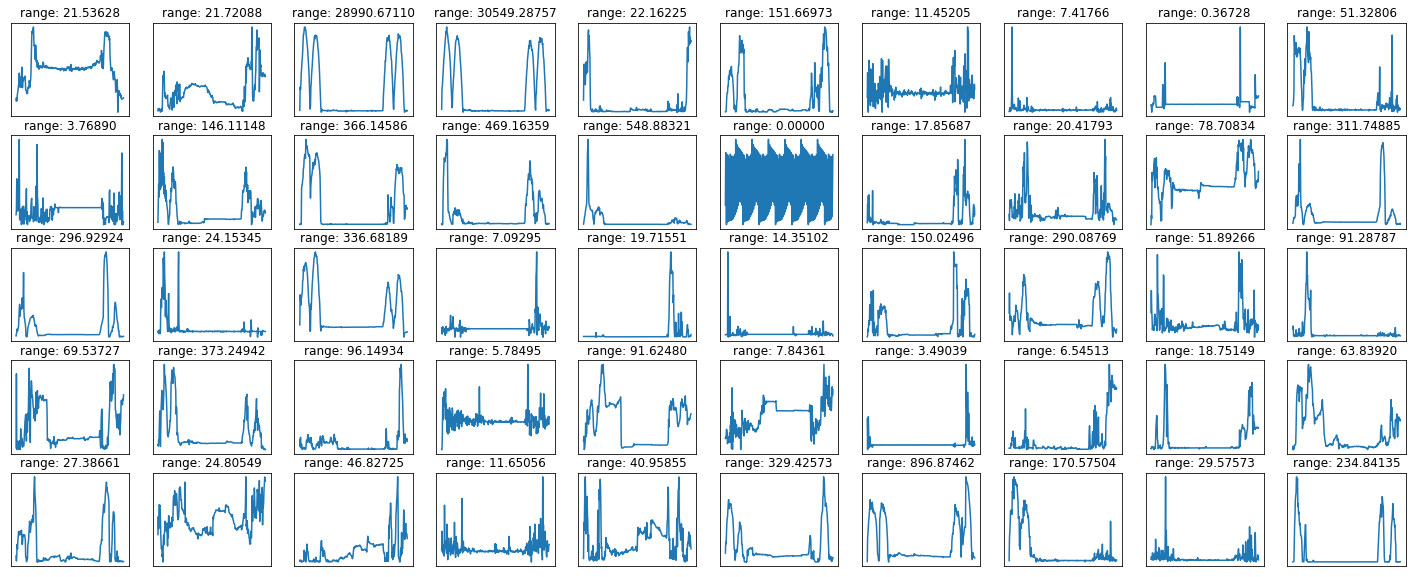

In [4]:
# show force changes over time for multiple particles
fig = plt.figure(figsize=(25, 10))
for idx in np.arange(50):
    ax = fig.add_subplot(5, 20/2, idx+1, xticks=[], yticks=[])
    ax.plot(data.iloc[idx,4:])
    # calculate force variation
    force_range = max(data.iloc[idx,4:]) - min(data.iloc[idx,4:]) 
    ax.set_title("range: {0:.5f}".format(force_range))


# Spline Regression

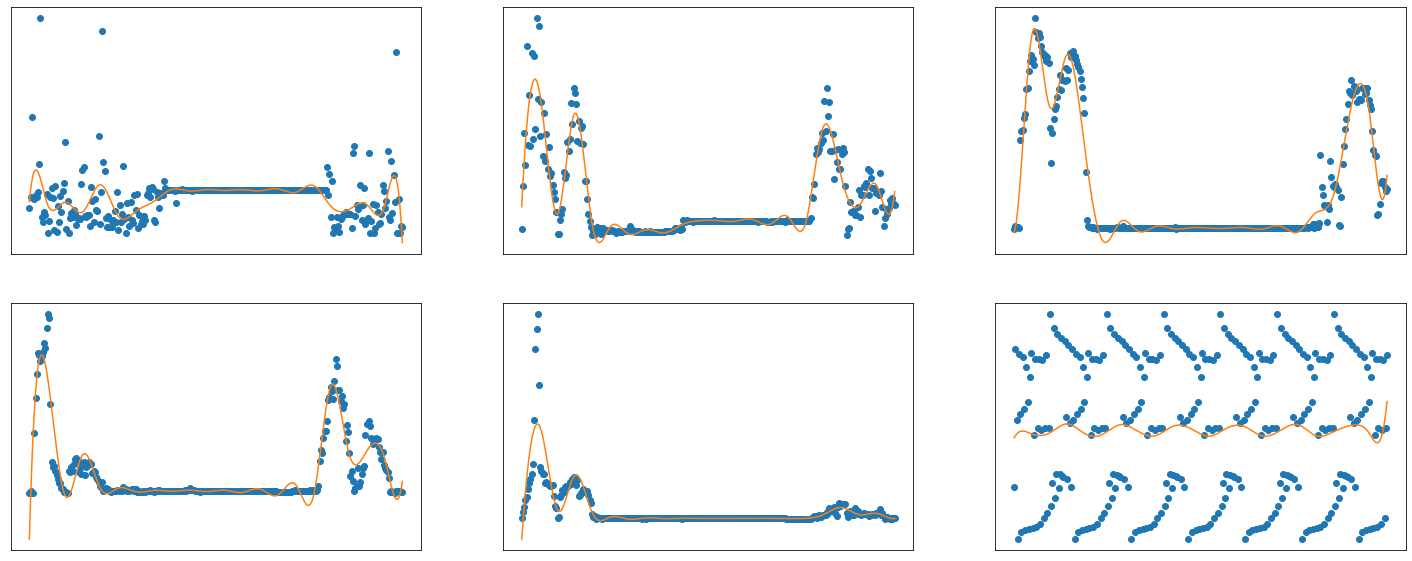

In [5]:
# set DEM related parameters
time_interval = 0.000002896586623472
record_per_step = 921
total_time = time_interval * record_per_step * 302

# define x axis values
x = np.linspace(0, total_time, num = 303)

# defind knots number and x axis values
knot_num = 20
knots = np.linspace(total_time * 1/(knot_num + 1), total_time * knot_num / (knot_num + 1), num = knot_num)

# plot data points and corresponding B—splines
fig = plt.figure(figsize=(25, 10))
for idx in np.arange(6):
    y = data.iloc[idx+10, 4:]

    # calculate B-spline coefficients
    tck = interpolate.splrep(x, y, task = -1, k = 3, t = knots)
    spline = interpolate.splev(x, tck)
    
    # plots
    ax = fig.add_subplot(2, 3, idx+1, xticks=[], yticks=[])
    ax.plot(x, y, 'o', label='data')
    ax.plot(x, spline, label="S")

# reference: https://en.wikipedia.org/wiki/De_Boor%27s_algorithm

### Choose knot number

knots number: 1, mask score:1754461.668869725
knots number: 2, mask score:1595546.6473377359
knots number: 3, mask score:1163370.8023022213
knots number: 4, mask score:1207545.1478288006
knots number: 5, mask score:1216680.1785860367
knots number: 6, mask score:1187715.2414751598
knots number: 7, mask score:1178002.083252795
knots number: 8, mask score:1193987.6447925852
knots number: 9, mask score:1151309.273879508
knots number: 10, mask score:1070606.4652851787
knots number: 11, mask score:984514.7756007193
knots number: 12, mask score:909452.0832995947
knots number: 13, mask score:797716.7511852687
knots number: 14, mask score:646968.1413006966
knots number: 15, mask score:526512.3947090147
knots number: 16, mask score:491170.3098366414
knots number: 17, mask score:514314.81778217107
knots number: 18, mask score:497844.5902459219
knots number: 19, mask score:404672.19267918274
knots number: 20, mask score:297867.1303701692
knots number: 21, mask score:240069.0711146572
knots number:

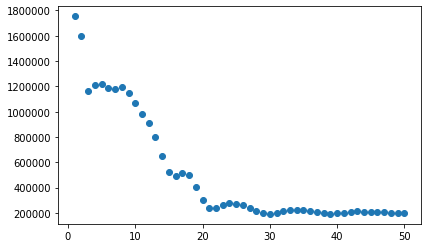

In [21]:
total_particle = len(data)

# create 10 groups from 1 to 10 for 10-fold cross validation
labels = np.random.randint(1, 11, size = 303)

validation_score = []

# loop through knots number options from 1 to 50
for knot_num in range(1, 51):
    mask_score = []
    # mask value is the corresponding validation group
    for mask in range(1, 11):
        # perform cross validation on the given fold
        knots = np.linspace(total_time * 1/(knot_num + 1), total_time * knot_num / (knot_num + 1), num = knot_num)
        row_score = data.iloc[:,4:].apply(lambda x: spline_validate(x, knots, labels, mask), axis=1)
        row_score_avg = np.mean(row_score)
        
        mask_score.append(row_score_avg)
    
    # print the 10-fold cross validation results
    print("knots number: {}, mask score:{}".format(knot_num, np.mean(mask_score)))
    validation_score.append(np.mean(mask_score))

# plot the 10-fold cross validation results
knots_range = np.linspace(1, 50, 50)

fig, ax = plt.subplots(figsize=(6.5, 4))
ax.plot(knots_range, validation_score, 'o')


### Calculate B-spline coefficients

In [6]:
# after determining the number of knots, perform spline regression on all the files, below is one case 
# read in files
folder = "lorss_d20out"
data = read_data(folder)

# set knot number and knot values
knot_num = 20
knots = np.linspace(total_time * 1/(knot_num + 1), total_time * knot_num / (knot_num + 1), num = knot_num)

# get B-spline coefficients
spline_coef = data.iloc[:,4:].apply(lambda x: get_spline_coef(x, knots), axis=1)
spline_coef_reshape = np.concatenate(spline_coef).reshape(-1,28)
spline_coef_reshape = pd.DataFrame(spline_coef_reshape)

# save coeeficients to a file in output folder
spline_coef_reshape.insert(0, "part_num", data["part_num"])
spline_coef_reshape.to_csv('../output/spline_coef_lorss_20.csv',header=True, index=False)
spline_coef_reshape.shape

(11777, 29)

# Clustering
### Center Binding

In [7]:
# read in files
folder = "cb_d16out"
data = read_data(folder)

In [8]:
# averaginh b-spline coefficients for eight train passes
spline_data = pd.DataFrame()

for i in range(8):
#     print(i)
    if spline_data.empty:
        file = '../output/spline_coef_cb_' + str(i+9) + '.csv'
        spline_data = pd.read_csv(file)
        spline_data = drop_nan(spline_data)
    else:
        
        file = '../output/spline_coef_cb_' + str(i+9) + '.csv'
        tmp = pd.read_csv(file)
        tmp = drop_nan(tmp)
        spline_data, tmp = match_partnum(spline_data, tmp)
        spline_data = spline_data.add(tmp)/2

spline_data.head()

,part_num,0,1,2,3,4,5,6,7,8,...,18,19,20,21,22,23,24,25,26,27
0,1.0,3.710979e+00,2.528662e+00,4.249809e+00,2.348652e+00,4.581181e+00,1.146151e+00,6.264495e+00,7.379643e+00,2.766440e+00,...,3.583004e+00,2.918062e+00,3.869539e+00,3.607005e+00,3.408697e+00,2.867899e+00,0.0,0.0,0.0,0.0
1,2.0,1.475688e+00,1.455010e+00,1.594952e+00,1.468053e+00,1.412397e+00,1.337863e+00,1.449650e+00,1.708264e+00,1.209904e+00,...,1.618023e+00,1.240944e+00,1.641122e+00,1.416571e+00,1.364541e+00,1.425421e+00,0.0,0.0,0.0,0.0
2,3.0,6.722906e+08,6.722983e+08,6.723341e+08,6.722738e+08,6.723312e+08,6.722856e+08,6.722853e+08,6.722867e+08,6.722858e+08,...,6.723281e+08,6.722906e+08,6.723066e+08,6.723209e+08,6.722701e+08,6.722904e+08,0.0,0.0,0.0,0.0
3,4.0,6.722924e+08,6.722972e+08,6.723397e+08,6.722729e+08,6.723353e+08,6.722863e+08,6.722851e+08,6.722871e+08,6.722858e+08,...,6.723325e+08,6.722904e+08,6.723097e+08,6.723249e+08,6.722685e+08,6.722911e+08,0.0,0.0,0.0,0.0
4,5.0,4.113470e+00,-9.293351e-01,1.119895e+01,3.585214e+00,9.548858e+00,1.871911e+00,2.617278e+00,2.143938e+00,2.665987e+00,...,7.662538e+00,1.306185e+01,6.819373e+00,5.478160e+00,2.917167e+00,4.610120e+00,0.0,0.0,0.0,0.0


In [9]:
# get particle x,y,z coordinates
data = drop_nan(data)
data, _ = match_partnum(data, spline_data)
coord = data.iloc[:,1:4]

# calculate pairwise distance between all particles
dist = distance.cdist(coord, coord, 'euclidean')
# get the index for the closest 19 coordinates
top_idx = np.apply_along_axis(sort_idx, 1, dist)

# apply 3x3 gaussian kernel to all particles
spline_kernel = apply_kernel(spline_data, top_idx)


In [10]:
import visualization_util as vs
# reload vs to incorporate any modification on the utility file
reload(vs)

<module 'visualization_util' from '/Users/bin/Documents/2_UIUC/2_Project/4_Amtrak Project/6. Ballast_Clustering/src/visualization_util.py'>

In [13]:
# if direct use spline_data for clustering
kmeans = cluster.KMeans(n_clusters = 5, n_init = 10, random_state = 0).fit(spline_data.iloc[:,4:25])

# check clustering distribution
print(Counter(kmeans.labels_))

# save labels to a csv file
label = pd.DataFrame({'part_num':spline_data["part_num"],'label':kmeans.labels_})
label.to_csv('../output/labels_force_cb.csv',header=True, index=False)

# visualization
vs.plot('../output/labels_force_cb.csv', 'CenterBinding.v3d','library.vlb')

Counter({0: 10627, 3: 750, 4: 46, 1: 2, 2: 1})


In [14]:
# if use spline_data for clustering with some preprocessing
kmeans = cluster.KMeans(n_clusters = 5, n_init = 10, random_state = 0).fit(np.log(np.abs(spline_data.iloc[:,4:25])+0.0001))

# check clustering distribution
print(Counter(kmeans.labels_))

# save labels to a csv file
label = pd.DataFrame({'part_num':spline_data["part_num"],'label':kmeans.labels_})
label.to_csv('../output/labels_force_cb.csv',header=True, index=False)

# visualization
vs.plot('../output/labels_force_cb.csv', 'CenterBinding.v3d','library.vlb')

Counter({3: 3630, 4: 3029, 0: 2493, 1: 1986, 2: 288})


In [15]:
# if direct use spline_kernel for clustering
kmeans = cluster.KMeans(n_clusters = 5, n_init = 10, random_state = 0).fit(spline_kernel.iloc[:,4:25])

# check clustering distribution
print(Counter(kmeans.labels_))

# save labels to a csv file
label = pd.DataFrame({'part_num':spline_data["part_num"],'label':kmeans.labels_})
label.to_csv('../output/labels_force_cb.csv',header=True, index=False)

# visualization
vs.plot('../output/labels_force_cb.csv', 'CenterBinding.v3d','library.vlb')

Counter({0: 11380, 4: 24, 3: 10, 2: 10, 1: 2})


In [16]:
# if use spline_kernel for clustering with some preprocessing
kmeans = cluster.KMeans(n_clusters = 5, n_init = 10, random_state = 0).fit(np.log(np.abs(spline_kernel.iloc[:,4:25])+0.0001))

# check clustering distribution
print(Counter(kmeans.labels_))

# save labels to a csv file
label = pd.DataFrame({'part_num':spline_data["part_num"],'label':kmeans.labels_})
label.to_csv('../output/labels_force_cb.csv',header=True, index=False)

# visualization
vs.plot('../output/labels_force_cb.csv', 'CenterBinding.v3d','library.vlb')

Counter({3: 4987, 2: 3236, 0: 2769, 4: 237, 1: 197})


In [19]:
# if use spline_kernel for clustering with some preprocessing
kmeans = cluster.KMeans(n_clusters = 5, n_init = 10, random_state = 0).fit(np.log(np.abs(spline_kernel.iloc[:,4:25])+0.0001))

# saving single label to csv file
tmp = [spline_data.iloc[idx,0] for idx, label in enumerate(kmeans.labels_) if label == 0]
label = pd.DataFrame({'part_num':tmp,'label':[0]*len(tmp)})

label.to_csv('../output/labels_force_single_cb.csv',header=True, index=False)

# visualization
vs.plot('../output/labels_force_single_cb.csv', 'CenterBinding.v3d','library.vlb')

### Full Support

In [31]:
# read in files
folder = "fs_d14out"
data = read_data(folder)

In [32]:
# averaginh b-spline coefficients for eight train passes
spline_data = pd.DataFrame()

for i in range(8):
#     print(i)
    if spline_data.empty:
        file = '../output/spline_coef_fs_' + str(i+7) + '.csv'
        spline_data = pd.read_csv(file)
        spline_data = drop_nan(spline_data)
    else:
        
        file = '../output/spline_coef_fs_' + str(i+7) + '.csv'
        tmp = pd.read_csv(file)
        tmp = drop_nan(tmp)
        spline_data, tmp = match_partnum(spline_data, tmp)
        spline_data = spline_data.add(tmp)/2

spline_data.head()

,part_num,0,1,2,3,4,5,6,7,8,...,18,19,20,21,22,23,24,25,26,27
0,1.0,6.887342e+00,7.038769e+00,1.240992e+01,1.227815e+01,1.687326e+01,1.356943e+01,1.279034e+01,1.226757e+01,1.150123e+01,...,1.364163e+01,9.392891e+00,1.547492e+01,1.127016e+01,1.353262e+01,1.456135e+01,0.0,0.0,0.0,0.0
1,2.0,2.118174e+00,2.273863e+00,2.694619e+00,3.206503e+00,3.005063e+00,1.465490e+00,1.974917e+00,2.742855e+00,2.148569e+00,...,2.924758e+00,2.537882e+00,2.420641e+00,2.413503e+00,1.610591e+00,1.792055e+00,0.0,0.0,0.0,0.0
2,3.0,1.003414e+09,1.003418e+09,1.003449e+09,1.003400e+09,1.003444e+09,1.003409e+09,1.003409e+09,1.003410e+09,1.003409e+09,...,1.003441e+09,1.003413e+09,1.003425e+09,1.003435e+09,1.003397e+09,1.003412e+09,0.0,0.0,0.0,0.0
3,4.0,1.003416e+09,1.003420e+09,1.003456e+09,1.003400e+09,1.003452e+09,1.003411e+09,1.003410e+09,1.003411e+09,1.003410e+09,...,1.003445e+09,1.003415e+09,1.003428e+09,1.003441e+09,1.003397e+09,1.003414e+09,0.0,0.0,0.0,0.0
4,5.0,1.921341e+00,2.702436e+00,6.197979e-01,2.171599e-01,1.828404e+00,1.480894e+00,2.874421e-01,9.430599e-01,4.988606e-01,...,7.430603e+00,7.090922e+00,1.008974e+00,2.134497e+01,-2.509786e+00,7.008923e+00,0.0,0.0,0.0,0.0


In [33]:
# get particle x,y,z coordinates
data = drop_nan(data)
data, _ = match_partnum(data, spline_data)
coord = data.iloc[:,1:4]

# calculate pairwise distance between all particles
dist = distance.cdist(coord, coord, 'euclidean')
# get the index for the closest 19 coordinates
top_idx = np.apply_along_axis(sort_idx, 1, dist)

# apply 3x3 gaussian kernel to all particles
spline_kernel = apply_kernel(spline_data, top_idx)


In [34]:
# if use spline_kernel for clustering with some preprocessing
kmeans = cluster.KMeans(n_clusters = 5, n_init = 10, random_state = 0).fit(np.log(np.abs(spline_kernel.iloc[:,4:25])+0.0001))

# check clustering distribution
print(Counter(kmeans.labels_))

# save labels to a csv file
label = pd.DataFrame({'part_num':spline_data["part_num"],'label':kmeans.labels_})
label.to_csv('../output/labels_force_fs.csv',header=True, index=False)

# visualization
vs.plot('../output/labels_force_fs.csv', 'FullSup.v3d','library.vlb')

Counter({0: 4008, 3: 3104, 4: 3061, 2: 244, 1: 202})


In [27]:
# if use spline_kernel for clustering with some preprocessing
kmeans = cluster.KMeans(n_clusters = 5, n_init = 10, random_state = 0).fit(np.log(np.abs(spline_kernel.iloc[:,4:25])+0.0001))

# saving single label to csv file
tmp = [spline_data.iloc[idx,0] for idx, label in enumerate(kmeans.labels_) if label == 4]
label = pd.DataFrame({'part_num':tmp,'label':[4]*len(tmp)})

label.to_csv('../output/labels_force_single_fs.csv',header=True, index=False)

# visualization
vs.plot('../output/labels_force_single_fs.csv', 'FullSup.v3d','library.vlb')

### Lack of Center Support

In [35]:
# read in files
folder = "locs_d16out"
data = read_data(folder)

In [36]:
# averaginh b-spline coefficients for eight train passes
spline_data = pd.DataFrame()

for i in range(8):
#     print(i)
    if spline_data.empty:
        file = '../output/spline_coef_locs_' + str(i+9) + '.csv'
        spline_data = pd.read_csv(file)
        spline_data = drop_nan(spline_data)
    else:
        
        file = '../output/spline_coef_locs_' + str(i+9) + '.csv'
        tmp = pd.read_csv(file)
        tmp = drop_nan(tmp)
        spline_data, tmp = match_partnum(spline_data, tmp)
        spline_data = spline_data.add(tmp)/2

spline_data.head()

,part_num,0,1,2,3,4,5,6,7,8,...,18,19,20,21,22,23,24,25,26,27
0,1.0,1.740982e+01,9.751957e+00,3.601461e+01,1.500945e+01,2.592544e+01,2.187210e+01,2.129007e+01,2.042240e+01,1.988032e+01,...,2.361696e+01,2.485971e+01,1.784203e+01,2.266732e+01,1.397718e+01,1.773966e+01,0.0,0.0,0.0,0.0
1,2.0,3.594107e+00,-1.611395e+00,1.555719e+01,2.023306e-01,4.440750e+00,6.217721e+00,2.919423e+00,6.175044e+00,5.609565e+00,...,6.549342e+00,9.039050e+00,4.485232e+00,1.683278e+01,3.881196e+00,9.673191e+00,0.0,0.0,0.0,0.0
2,3.0,1.774731e+09,1.774737e+09,1.774779e+09,1.774714e+09,1.774773e+09,1.774726e+09,1.774726e+09,1.774727e+09,1.774727e+09,...,1.774768e+09,1.774730e+09,1.774747e+09,1.774761e+09,1.774710e+09,1.774731e+09,0.0,0.0,0.0,0.0
3,4.0,1.774735e+09,1.774743e+09,1.774781e+09,1.774717e+09,1.774778e+09,1.774729e+09,1.774731e+09,1.774731e+09,1.774731e+09,...,1.774771e+09,1.774733e+09,1.774751e+09,1.774764e+09,1.774715e+09,1.774735e+09,0.0,0.0,0.0,0.0
4,5.0,8.757173e+00,4.611888e+00,1.202008e+01,-2.880137e+00,2.387018e+00,5.538853e-01,8.799838e+00,6.528037e+00,7.876882e+00,...,1.698057e+00,1.016995e+00,2.715038e+00,-2.011677e+00,1.410262e+01,1.154641e+01,0.0,0.0,0.0,0.0


In [37]:
# get particle x,y,z coordinates
data = drop_nan(data)
data, _ = match_partnum(data, spline_data)
coord = data.iloc[:,1:4]

# calculate pairwise distance between all particles
dist = distance.cdist(coord, coord, 'euclidean')
# get the index for the closest 19 coordinates
top_idx = np.apply_along_axis(sort_idx, 1, dist)

# apply 3x3 gaussian kernel to all particles
spline_kernel = apply_kernel(spline_data, top_idx)


In [38]:
# if use spline_kernel for clustering with some preprocessing
kmeans = cluster.KMeans(n_clusters = 5, n_init = 10, random_state = 0).fit(np.log(np.abs(spline_kernel.iloc[:,4:25])+0.0001))

# check clustering distribution
print(Counter(kmeans.labels_))

# save labels to a csv file
label = pd.DataFrame({'part_num':spline_data["part_num"],'label':kmeans.labels_})
label.to_csv('../output/labels_force_locs.csv',header=True, index=False)

# visualization
vs.plot('../output/labels_force_locs.csv', 'LackofCenterSup.v3d','library.vlb')

Counter({4: 3822, 1: 3810, 0: 3293, 2: 271, 3: 209})


In [41]:
# if use spline_kernel for clustering with some preprocessing
kmeans = cluster.KMeans(n_clusters = 5, n_init = 10, random_state = 0).fit(np.log(np.abs(spline_kernel.iloc[:,4:25])+0.0001))

# saving single label to csv file
tmp = [spline_data.iloc[idx,0] for idx, label in enumerate(kmeans.labels_) if label == 0]
label = pd.DataFrame({'part_num':tmp,'label':[0]*len(tmp)})

label.to_csv('../output/labels_force_single_locs.csv',header=True, index=False)

# visualization
vs.plot('../output/labels_force_single_locs.csv', 'LackofCenterSup.v3d','library.vlb')

### Lack of Rail Seat Support 

In [44]:
# read in files
folder = "lorss_d20out"
data = read_data(folder)

In [46]:
# averaginh b-spline coefficients for eight train passes
spline_data = pd.DataFrame()

for i in range(8):
#     print(i)
    if spline_data.empty:
        file = '../output/spline_coef_lorss_' + str(i+13) + '.csv'
        spline_data = pd.read_csv(file)
        spline_data = drop_nan(spline_data)
    else:
        
        file = '../output/spline_coef_lorss_' + str(i+13) + '.csv'
        tmp = pd.read_csv(file)
        tmp = drop_nan(tmp)
        spline_data, tmp = match_partnum(spline_data, tmp)
        spline_data = spline_data.add(tmp)/2

spline_data.head()

,part_num,0,1,2,3,4,5,6,7,8,...,18,19,20,21,22,23,24,25,26,27
0,1.0,1.029212e+01,7.215779e+00,1.659930e+01,6.920326e+00,1.563903e+01,9.898784e+00,1.207512e+01,1.042220e+01,1.159492e+01,...,1.402106e+01,1.308126e+01,1.375925e+01,1.739702e+01,1.002689e+01,1.293162e+01,0.0,0.0,0.0,0.0
1,2.0,1.362572e+01,-4.200717e+00,2.867973e+01,2.073271e-02,2.757177e+01,1.181057e+01,9.540102e+00,1.249522e+01,1.200716e+01,...,2.058347e+01,1.898366e+01,1.896016e+01,3.342069e+01,-7.026291e-01,1.371883e+01,0.0,0.0,0.0,0.0
2,3.0,6.855132e+08,6.855189e+08,6.855559e+08,6.854949e+08,6.855515e+08,6.855067e+08,6.855091e+08,6.855087e+08,6.855089e+08,...,6.855475e+08,6.855102e+08,6.855305e+08,6.855370e+08,6.854952e+08,6.855128e+08,0.0,0.0,0.0,0.0
3,4.0,6.855136e+08,6.855204e+08,6.855653e+08,6.854931e+08,6.855585e+08,6.855065e+08,6.855091e+08,6.855093e+08,6.855091e+08,...,6.855547e+08,6.855103e+08,6.855348e+08,6.855446e+08,6.854912e+08,6.855139e+08,0.0,0.0,0.0,0.0
4,5.0,4.237808e-01,4.664535e-01,5.054901e-01,3.859441e-01,5.487273e-01,4.472057e-01,2.140726e-01,4.900767e-01,3.052252e-01,...,6.118952e-01,2.430348e-01,4.177356e-01,6.364776e-01,4.322590e-01,3.350919e-01,0.0,0.0,0.0,0.0


In [47]:
# get particle x,y,z coordinates
data = drop_nan(data)
data, _ = match_partnum(data, spline_data)
coord = data.iloc[:,1:4]

# calculate pairwise distance between all particles
dist = distance.cdist(coord, coord, 'euclidean')
# get the index for the closest 19 coordinates
top_idx = np.apply_along_axis(sort_idx, 1, dist)

# apply 3x3 gaussian kernel to all particles
spline_kernel = apply_kernel(spline_data, top_idx)


In [52]:
# if use spline_kernel for clustering with some preprocessing
kmeans = cluster.KMeans(n_clusters = 5, n_init = 10, random_state = 0).fit(np.log(np.abs(spline_kernel.iloc[:,4:25])+0.0001))

# check clustering distribution
print(Counter(kmeans.labels_))

# save labels to a csv file
label = pd.DataFrame({'part_num':spline_data["part_num"],'label':kmeans.labels_})
label.to_csv('../output/labels_force_lorss.csv',header=True, index=False)

# visualization
vs.plot('../output/labels_force_lorss.csv', 'LackofRailSeatSup.v3d','library.vlb')

Counter({1: 6753, 0: 4669, 2: 355})


In [51]:
# if use spline_kernel for clustering with some preprocessing
kmeans = cluster.KMeans(n_clusters = 5, n_init = 10, random_state = 0).fit(np.log(np.abs(spline_kernel.iloc[:,4:25])+0.0001))

# saving single label to csv file
tmp = [spline_data.iloc[idx,0] for idx, label in enumerate(kmeans.labels_) if label == 4]
label = pd.DataFrame({'part_num':tmp,'label':[4]*len(tmp)})

label.to_csv('../output/labels_force_single_lorss.csv',header=True, index=False)

# visualization
vs.plot('../output/labels_force_single_lorss.csv', 'LackofRailSeatSup.v3d','library.vlb')